#Import Packages

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import datetime
import sys, os
import matplotlib.pyplot as plt
import sklearn as sk
import plotly.express as px
import seaborn as sns
import ipywidgets as widgets
import xgboost as xgb
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from scipy import signal
import statsmodels.api as sm
from matplotlib import figure
import requests


In [ ]:
#for installing streamlit
#uncomment to install
#!pip install streamlit
#!xcode-select --install

In [ ]:
#for installing dash
#!pip install jupyter-dash

In [ ]:
#To allow plotly to run in colab
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

#Dict for SNOTEL sites and ID's

In [ ]:
SNOTEL_dict = {
  'adin': '301',
  'blue_lakes': '356',
  'burnside_lake': '1051',
  'carson_pass': '1067',
  'cedar_pass': '391',
  'css_lab': '428',
  'dismal_swamp': '446',
  'ebbetts_pass': '462',
  'echo_peak': '463',
  'fallen_leaf': '473', 
  'hagans_meadow': '508',
  'heavenly_valley': '518',
  'independence_camp': '539',
  'independence_creek': '540',
  'independence_lake': '541',
  'leavitt_lake': '574',
  'leavitt_meadows': '575',
  'lobdell_lake': '587',
  'monitor_pass': '633', 
  'poison_flat': '697',
  'rubicon_2': '724',
  'sonora_pass': '771',
  'spratt_creek': '778',
  'palisades_tahoe': '784',
  'tahoe_city_cross': '809',
  'truckee_2': '834', 
  'virginia_lakes_ridge': '846',
  'ward_creek_3': '848',
  # 'crowder_flat': '977', 
  # 'forestdale_creek': '1049',
  # 'horse_meadow': '1050',
  # 'summit_meadow': '1052',
  # 'state_line': '1258', 
  # 'fredonyer_peak': '1277'
}

#SNOTEL SOAP (API) requests SWE

In [ ]:
from bs4 import BeautifulSoup
import xml.etree.ElementTree as ET
from datetime import datetime

In [ ]:
url="https://wcc.sc.egov.usda.gov/awdbWebService/services?WSDL"
headers = {'content-type': 'application/soap+xml'}
curr_date = f'{datetime.today().year}-{datetime.today().month}-{datetime.today().day}'
def soap_request(snotel_id):
  #replace endDate with function that returns today's date in that format
  #create array of all station ID's for call and replace 301 with the array call
  body = f"""<?xml version="1.0" encoding="UTF-8"?>
            <SOAP-ENV:Envelope xmlns:SOAP-ENV="http://schemas.xmlsoap.org/soap/envelope/" xmlns:q0="http://www.wcc.nrcs.usda.gov/ns/awdbWebService" xmlns:xsd="http://www.w3.org/2001/XMLSchema" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance">
              <SOAP-ENV:Body>
                <q0:getData>
                  <stationTriplets>{snotel_id}:CA:SNTL</stationTriplets>
                  <elementCd>WTEQ</elementCd>
                  <ordinal>1</ordinal>
                  <duration>DAILY</duration>
                  <getFlags>false</getFlags>
                  <beginDate>1985-10-01</beginDate>
                  <endDate>{curr_date}</endDate> 
                  <alwaysReturnDailyFeb29>false</alwaysReturnDailyFeb29>
                </q0:getData>
              </SOAP-ENV:Body>
            </SOAP-ENV:Envelope>"""
  df = pd.DataFrame()
  arr = []
  response = requests.post(url,data=body,headers=headers).content
  root = ET.fromstring(response)
  for child in root[0][0][0][4:]:
   arr.append(child.text)

  df['SWE(in)'] = arr
  df['date'] = pd.date_range('10/01/1985', periods = len(arr))

  return df, arr



#SOAP request Accumulated Precipitation

In [ ]:
url="https://wcc.sc.egov.usda.gov/awdbWebService/services?WSDL"
headers = {'content-type': 'application/soap+xml'}
curr_date = f'{datetime.today().year}-{datetime.today().month}-{datetime.today().day}'

def soap_request_precip(snotel_id):
  body = f'''<?xml version="1.0" encoding="UTF-8"?>
            <SOAP-ENV:Envelope xmlns:SOAP-ENV="http://schemas.xmlsoap.org/soap/envelope/" xmlns:q0="http://www.wcc.nrcs.usda.gov/ns/awdbWebService" xmlns:xsd="http://www.w3.org/2001/XMLSchema" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance">
              <SOAP-ENV:Body>
                <q0:getData>
                  <stationTriplets>{snotel_id}:CA:SNTL</stationTriplets>
                  <elementCd>PREC</elementCd>
                  <ordinal>1</ordinal>
                  <duration>DAILY</duration>
                  <getFlags>false</getFlags>
                  <beginDate>1985-10-01</beginDate>
                  <endDate>{curr_date}</endDate>
                  <alwaysReturnDailyFeb29>false</alwaysReturnDailyFeb29>
                </q0:getData>
              </SOAP-ENV:Body>
            </SOAP-ENV:Envelope>'''

  df = pd.DataFrame()
  arr = []
  response = requests.post(url,data=body,headers=headers).content
  root = ET.fromstring(response)
  for child in root[0][0][0][4:]:
    arr = np.append(arr, child.text)

  df['Accumulated_Precipitation'] = arr
  df['date'] = pd.date_range('10/01/1985', periods = len(arr))

  return df



# Merge Tables

Reading new files and cleaning them

In [ ]:
def data_cleaning(sheet_name):
  sheet = pd.read_excel(data, sheet_name)
  sheet.to_csv(f'{sheet_name}.csv')
  cleaned = pd.read_csv(sheet_name + ".csv", sep = ";", header = None)
  df = cleaned[0].str.split(',', expand=True)
  df = df.iloc[:, 1:]
  df.iloc[1:, 0] = df.iloc[1:, 0].str.replace('-', '').str.replace('"', '')
  new_header = df.iloc[0].str.replace('"', '')
  df = df[1:].applymap(lambda x: x.replace('"', ''))
  df.columns = new_header
  return df, sheet_name

In [ ]:
def sum_monthly(df, column):
  df.loc[:, [column]] = df.loc[:, [column]].astype(float)
  df = df.groupby(pd.Grouper(key="date", freq="1M")).sum()
  df['d'] = df.index
  df['d'] = df['d'].astype('datetime64[M]')
  return df

In [ ]:
#sum precip data
def merge_tables(SNOTEL_id):
  x = sum_monthly(soap_request(SNOTEL_id)[0], 'SWE(in)')
  z = sum_monthly(soap_request_precip(SNOTEL_id), 'Accumulated_Precipitation')
  x1 = x.merge(temp, left_on='d', right_on = 'DATE')
  x1['month'] = x1['d'].dt.month

  pdo = scrape_pdo()
  ao = scrape_ao()

  x1 = x1.merge(pdo, left_on='d', right_on = 'Date', how = 'left')
  x1 = x1.merge(ao, left_on='d', right_on = 'Date', how = 'left')
  x1 = x1.merge(z, left_on='d', right_on = 'd', how = 'left' )

  return x1

#Scraping ENSO Data

In [ ]:
enso_webpage = requests.get('https://www.cpc.ncep.noaa.gov/data/indices/sstoi.indices')

In [ ]:
features = ['month','NINO12','NINO3','NINO3.4','NINO4', 'anomaly']

In [ ]:
from pandas.core.api import date_range
import csv

def scrape_enso():
  pd.DataFrame(str(enso_webpage.content).replace("   ", ' ').replace("  ", " ").replace(' ', ';').replace('b', ';').replace('n', ';')\
              .replace("'", "").replace('+', "").replace("MON", 'month').split('\\')).to_csv('enso.csv')
  df = pd.read_csv('enso.csv', delimiter = ";", header = 1)
  df = df.drop(columns = {'0,'})
  df['DATE'] = pd.date_range('1982-01-01', periods = df.shape[0], freq = "1M")
  arr = []
  for i in range(len(df['DATE'])):
    df['DATE'][i] = df['DATE'][i].replace(day = 1)
  
  return df

In [ ]:
temp = scrape_enso()

#Scraping PDO Data

In [ ]:
pdo_webpage = requests.get('https://www.ncei.noaa.gov/pub/data/cmb/ersst/v5/index/ersst.v5.pdo.dat')

In [ ]:
def scrape_pdo():
  arr = []
  pdo_temp = pd.DataFrame()

  f = str(pdo_webpage.content[18:])
  pd.DataFrame(str(pdo_webpage.content[18:]).replace("   ", ';').replace("  ", ";").replace(' ', ';').replace(',', ';')\
              .replace("'", "").split('\\n')).to_csv("pdo.csv")
  df = pd.read_csv('pdo.csv', delimiter = ";", header = 1)
  df["0,bYear"] = pd.date_range('1854-10-01', periods = df.shape[0], freq = '1Y')
  for i in range(len(df['0,bYear'])):
    df['0,bYear'][i] = df['0,bYear'][i].replace(day = 1).replace(month = 1)
  df = df[df['0,bYear'] >= '1984-10-01']
  for i in range(len(df.iloc[1:, 0])):
    for j in range(1, len(df.columns)):
      arr.append(df.iloc[i, j])

  pdo_temp['pdo_data'] = arr
  pdo_temp['Date'] = pd.date_range('1985-01-01', periods = len(arr), freq = '1M')
  for i in range(len(pdo_temp['Date'])):
    pdo_temp['Date'][i] = pdo_temp['Date'][i].replace(day = 1)

  pdo_temp = pdo_temp[pdo_temp['pdo_data'] != 99.99]

  return pdo_temp


#Scrape AO Data

In [ ]:
ao_webpage = requests.get('https://www.cpc.ncep.noaa.gov/products/precip/CWlink/daily_ao_index/monthly.ao.index.b50.current.ascii.table')

In [ ]:
import math

In [ ]:
def scrape_ao():
  arr = []
  return_table = pd.DataFrame()


  pd.DataFrame(str(ao_webpage.content).replace("      ", ';').replace("    ", ';').replace("   ", ';').replace("  ", ";").replace(' ', ';').replace(',', ';')\
                .replace("'", "").split('\\n')).to_csv("ao.csv")
  df = pd.read_csv('ao.csv', delimiter = ";", header = 1)
  df["0,b"] = pd.date_range('1950-10-01', periods = df.shape[0], freq = '1Y')
  for i in range(len(df['0,b'])):
    df['0,b'][i] = df['0,b'][i].replace(day = 1).replace(month = 1)
  df = df[df['0,b'].dt.year > 1984]
  df = df.drop(columns = {'Unnamed: 13'})
  for i in range(len(df.iloc[1:, 0])):
    for j in range(1, len(df.columns)):
      arr.append(df.iloc[i, j])

  new_list = [item for item in arr if not(math.isnan(item)) == True]

  return_table['ao_data'] = new_list
  return_table['Date'] = pd.date_range("1985-01-01", periods = len(new_list), freq = "1M")

  for i in range(len(return_table['Date'])):
    return_table['Date'][i] = return_table['Date'][i].replace(day = 1)

  return return_table


#Seasonal Decomposition?

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
def seasonally_decompose(ff, column):
  sd = seasonal_decompose(ff[column])
  ff[f'{column}_seasonal'] = sd.seasonal

  return ff

In [ ]:
lag_table = pd.DataFrame()

def lagged(ff, column):

  df = pd.DataFrame({"Predicted": ff['Accumulated_Precipitation'], "Data": ff[column]})


  for i in np.arange(-12,36):
    df[f"lag_{i}"] = df['Data'].shift(periods=i)

  a = np.array(abs(df.corr().iloc[0, 1:].values))

  ind = 0
  m = 0

  for i in range(len(a)):
    if a[i] > m:
      m = a[i]
      ind = i - 12 - 1

  ff[f'{column}_shifted'] = ff[column].shift(periods = ind)

  return ff

In [ ]:
features_iloc = [0,3,4,5,6,7,8,9,10,11,15,17]
seasonal_columns = ['ANOM', 'ANOM.1', 'ANOM.2', 'ANOM.3', 'pdo_data', 'ao_data']
final_feats = ['SWE(in)', 'Accumulated_Precipitation','month_shifted', 'NINO12_shifted','NINO3_shifted','NINO4_shifted',\
               'NINO3.4_shifted','ANOM_seasonal_shifted','ANOM.1_seasonal_shifted','ANOM.2_seasonal_shifted',\
               'ANOM.3_seasonal_shifted','pdo_data_seasonal_shifted','ao_data_seasonal_shifted']

def table_creation(SNOTEL_id):

  df = merge_tables(SNOTEL_id)
  df.index = df['d']
  df = df[:-1]

  for i in seasonal_columns:
    seasonally_decompose(df, i)

  for c in df.columns[1:]:
    lagged(df, c)

  df = df[final_feats]

  df = df.iloc[36:-12]

  return df

#Table with historic SNOTEL data

In [ ]:
new_table = pd.DataFrame()

for i in SNOTEL_dict:
  new_table[f'{i}'] = sum_monthly(soap_request_precip(SNOTEL_dict[i]), 'Accumulated_Precipitation')['Accumulated_Precipitation']

KeyboardInterrupt: ignored

In [ ]:
d = pd.read_csv('predicted_year.csv')

d.index = pd.date_range(start = '2021-11-01', freq = '1M', periods = 36)

historic_with_predicted_table = d.merge(new_table, right_index = True, left_index = True, how = 'outer')

FileNotFoundError: ignored

In [ ]:
historic_with_predicted_table.to_csv("historic_and_predicted.csv")

In [ ]:
d = historic_with_predicted_table

plt.plot(d.index, d['adin'])
plt.plot(d.index, d['adin_predicted'])


# Machine Learning

In [ ]:
plt.rcParams.update({"figure.figsize": (17,3), 'figure.dpi':300})

In [ ]:
#shifted_table should be the final formatted and clean table with as much good data as possible

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.metrics import RootMeanSquaredError
from keras.callbacks import EarlyStopping, ModelCheckpoint



In [ ]:
#This function saves the model but doesn't output predicted values

def create_fit_save_model(SNOTEL_id):
  df = table_creation(SNOTEL_id)

  callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min'),
    ModelCheckpoint(f'best_{SNOTEL_id}_model.h5', monitor='val_loss', save_best_only=True, verbose=0),
  ]

  scaler = MinMaxScaler()
  scaler = scaler.fit(df)

  scaled_df = scaler.transform(df)

  train_dates = df.index

  trainX = []
  trainY = []

  n_future = 36 #Number of months we want to see into the future
  n_past = 240 #Number of months we want to use to see into the future

  for i in range(n_past, len(scaled_df) - n_future + 1):
    trainX.append(scaled_df[i - n_past:i, 0:scaled_df.shape[1]])
    trainY.append(scaled_df[i + n_future - 1:i + n_future, 1])

  trainX, trainY = np.array(trainX), np.array(trainY)
  
  model = Sequential()
  model.add(LSTM(64, activation = 'relu', input_shape = (trainX.shape[1], trainX.shape[2]), return_sequences = True))
  model.add(LSTM(32, activation = 'relu', return_sequences = False))
  model.add(Dropout(0.2))
  model.add(Dense(trainY.shape[1]))

  model.compile(optimizer = 'adam', loss = 'mse')

  #Lots of epochs, small batch size, function in callbacks stops training when val_loss plateaus preventing overfitting
  history = model.fit(trainX, trainY, epochs = 250, batch_size = 5, validation_split = .2, verbose = 1, callbacks=callbacks)

  forecast_dates = pd.date_range(list(train_dates)[-1], periods = n_future, freq = '1M').tolist()

  forecast = model.predict(trainX[-n_future:])

  forecast_copied = np.repeat(forecast, scaled_df.shape[1], axis = -1)
  y_future = scaler.inverse_transform(forecast_copied)[:, 0]

  for i in range(len(y_future)):
    if y_future[i] < 0:
      y_future[i] = 0


  print(history.history.keys())
  loss_per_epoch = history.history['loss']
  plt.plot(range(len(loss_per_epoch)), loss_per_epoch, label = 'loss')

  loss2_per_epoch = history.history['val_loss']
  plt.plot(range(len(loss2_per_epoch)), loss2_per_epoch, label = 'validation loss')

  plt.xlabel('Number of epochs')
  plt.legend()


  return y_future

In [ ]:
# predicted_val_table = pd.DataFrame()

# for i in SNOTEL_dict:
#   try:
#     predicted_val_table[f'{i}_predicted'] = create_fit_save_model(SNOTEL_dict[i])
#   except:
#     pass

In [ ]:
j = pd.DataFrame(pd.to_datetime(predicted_val_table.index))

for i in range(len(j.iloc[:, 0])):
  j.iloc[i, 0] = j.iloc[i, 0].replace(day = 1)

j[0]

NameError: ignored

In [ ]:
n_future = 12 #Months we want to look into the future
forecast_dates = pd.date_range(list(train_dates)[-1], periods = n_future, freq = '1M').tolist()

In [ ]:
d = pd.DataFrame({"Historic": new_table['sonora_pass'].values, \
                  'Date': pd.date_range(start = '1985-10-01', periods = len(new_table['spratt_creek'].values), freq = '1M')})
dd = pd.DataFrame({"Predicted": x, 'Date': pd.date_range('2021-10-01', periods = len(x), freq = '1M')})

fff = d.merge(dd, how = 'outer')
fff.index = fff['Date']

plt.plot(fff['Historic'])
plt.plot(fff['Predicted'])

In [ ]:
forecast = model.predict(trainX[-n_future:])

In [ ]:
forecast_copied = np.repeat(forecast, scaled_df.shape[1], axis = -1)
y_future = scaler.inverse_transform(forecast_copied)[:, 0]

In [ ]:
forecast_with_date = []

for time_i in forecast_dates:
  forecast_with_date.append(time_i.date())

In [ ]:
for i in range(len(y_future)):
  if y_future[i] < 0:
    y_future[i] = 0

In [ ]:
df_forecast = pd.DataFrame({'Date': np.array(forecast_with_date), 'Predicted_val':y_future})

In [ ]:
df_forecast['Date'] = pd.to_datetime(df_forecast['Date'])

In [ ]:
df = df[['SWE(in)']]

In [ ]:
sns.lineplot(x = df.index, y = df['SWE(in)'])
sns.lineplot(x = df_forecast['Date'], y = df_forecast['Predicted_val'])

#Linear Regression

To Do:

~~Split into test and train, how to do with time series?~~

~~Create function to check error~~

(For the rest of this project):
Keep optimizing model, and test new models. (~~Linear, SARIMAX, XGBOOST~~, LTSM, VAR)

~~This model is doing poorly and anomaly data isn't a great indicator of precipitation, lets ask Andrew about adding features.~~

Can we get error for existing data below 5%?

In [ ]:
final_table = pd.DataFrame()
for i in sites:
  #I need to find a way to append site name to dataframe
  x = merge_table(data_cleaning(i))
  final_table = final_table.append(x)

In [ ]:
final_table = x1.sort_values('date')

In [ ]:
# from google.colab import files

# final_table.to_csv('combined_table.csv') 
# files.download('combined_table.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Not the correct way to train and test split for time series analysis
#train, test = train_test_split(final_table)

In [ ]:
#train = train.sort_values('d')
#test = test.sort_values('d')

In [ ]:
model = linear_model.LinearRegression()
X_features = shifted_table.loc[:, ['NINO12', 'NINO3', 'NINO4', 'NINO3.4', 'month']].to_numpy()
pred_feature = shifted_table[['predicted']].to_numpy()
model.fit(X_features, pred_feature)
preds = model.predict(X_features)

In [ ]:
#probably shouldn't do this but idk
for i in range(len(preds)):
  if preds[i] < 0:
    preds[i] = 0

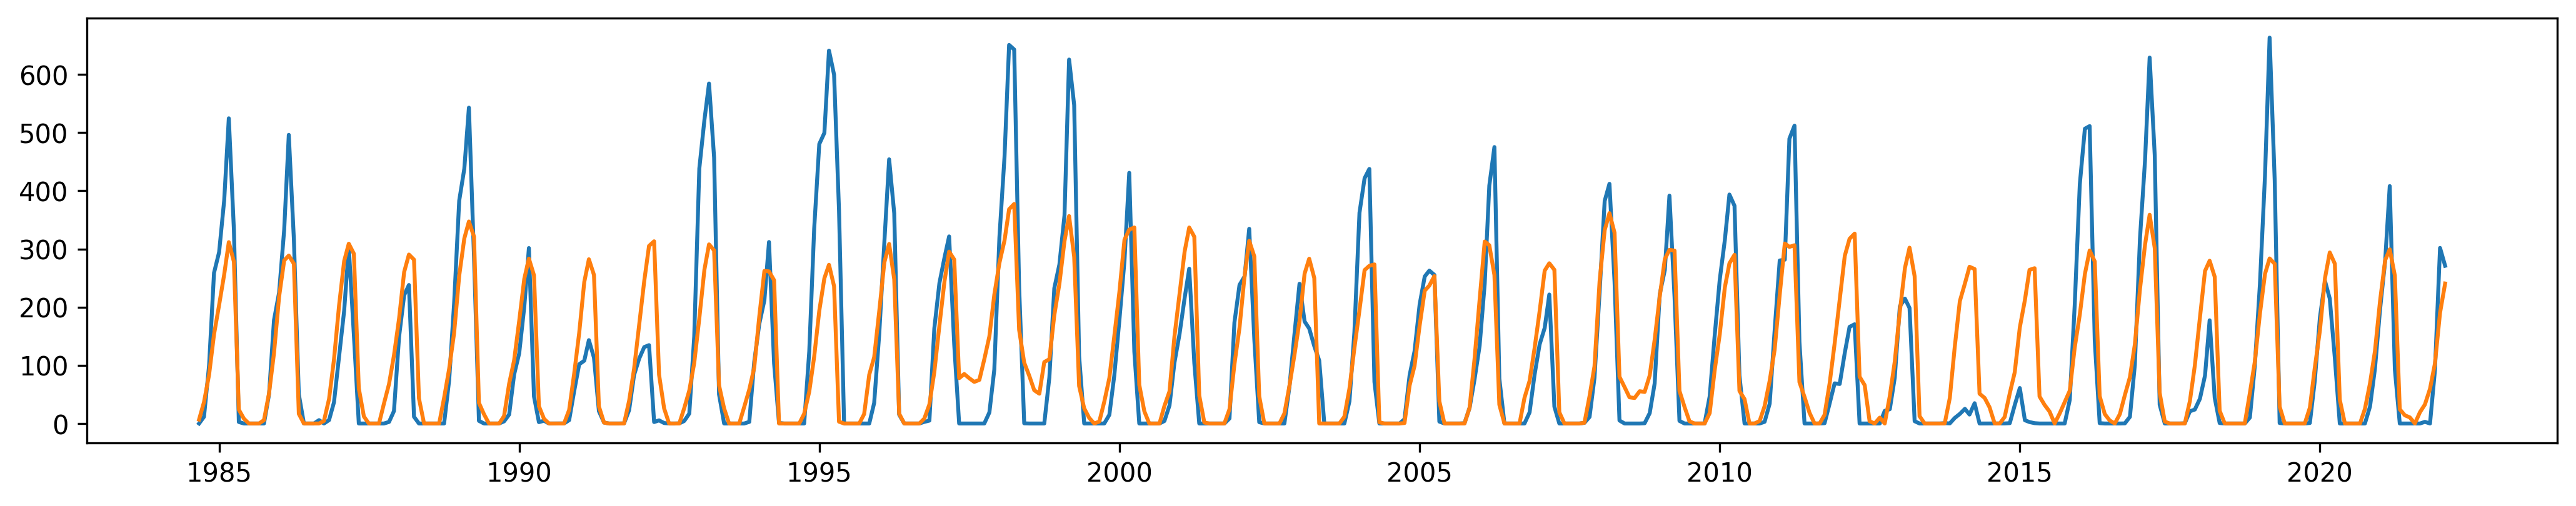

In [ ]:
#this should not be included in final result, just to remove one extreme outlier
plt.plot(shifted_table['date'], shifted_table['predicted'])
plt.plot(shifted_table['date'], preds)

The results from using a linear regression model have been not as good as wanted. It has trouble predicted high peaks, and valleys. Going forward let's try some new models.

In [ ]:
from sklearn.metrics import mean_squared_error

y_predicted = preds
y_actual = shifted_table['predicted']

#Lets get this number low
mean_squared_error(y_actual, y_predicted, squared=False)

95.00040602408349

#(S)ARIMAX (Not valid)

In [ ]:
shifted_table = shifted_table[['date', 'month', 'predicted','NINO12','NINO3','NINO3.4','NINO4']]

In [ ]:
shifted_table.index = shifted_table['date']

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose

res = seasonal_decompose(shifted_table['predicted'])
#res.plot();

In [ ]:
auto_arima(shifted_table['predicted'], trace = True).summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=5270.956, Time=1.09 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=5826.499, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=5440.591, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=5453.096, Time=0.34 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5993.004, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=5311.003, Time=0.70 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=5292.128, Time=0.71 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=5270.357, Time=1.24 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=5282.364, Time=1.18 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=5272.765, Time=1.41 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.50 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=5232.086, Time=1.27 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=5306.256, Time=0.87 sec
 ARIMA(2,0,4)(0,0,0)[0] intercept   : AIC=inf, Time=1.63 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=5

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  450
Model:               SARIMAX(3, 0, 4)   Log Likelihood               -2593.177
Date:                Sun, 13 Nov 2022   AIC                           5204.353
Time:                        01:57:15   BIC                           5241.336
Sample:                    09-01-1984   HQIC                          5218.930
                         - 02-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     34.4399      9.078      3.794      0.000      16.648      52.232
ar.L1          1.5752      0.247      6.373      0.000       1.091       2.060
ar.L2         -0.7296      0.428     -1.705      0.088      -1.568       0.109
ar.L3         -0.1549      0.246     -0.629      0.530      -0.638       0.328
ma.L1         -0.6378      0.244     -2.613      0.009      -1.116      -0.159
ma.L2         -0.4513      0.220     -2.051      0.040      -0.883      -0.020
ma.L3          0.3884      0.119      3.257      0.001       0.155       0.622
ma.L4          0.3675      0.190      1.939      0.053      -0.004       0.739
sigma2      6483.2115    353.641     18.333      0.000    5790.088    7176.335
===================================================================================
Ljung-Box (L1) (Q):                   0.64   Jarque-Bera (JB):               113.09
Prob(Q):                              0.42   Prob(JB):                         0.00
Heteroskedasticity (H):               1.00   Skew:                             0.26
Prob(H) (two-sided):                  1.00   Kurtosis:                         5.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



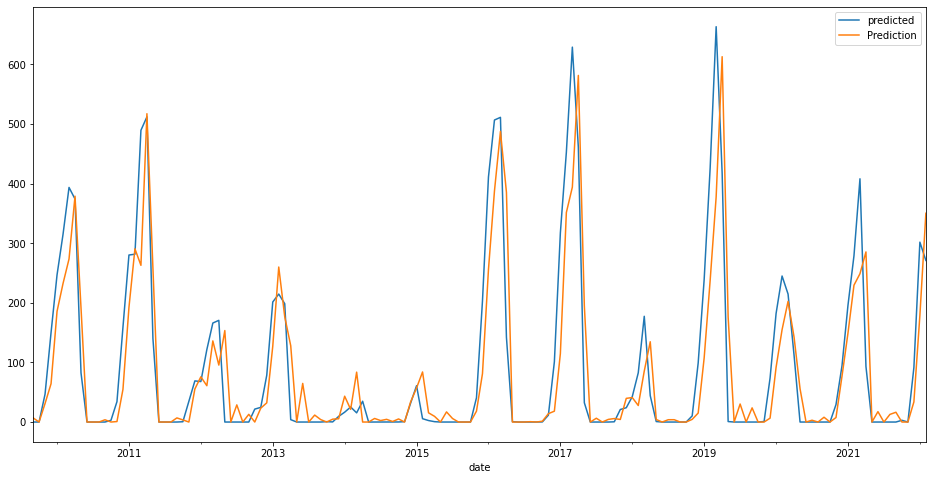

In [ ]:
#SARIMAX(3,0,4)(0,0,0)[0]
#With no features, ie no Ocean temp data
len(shifted_table)
mod = SARIMAX(shifted_table['predicted'], order = (4,0,1), seasonal_order=(0,0,2,30))
res = mod.fit()
start = len(train_df)
end = len(train_df) + len(test_df) - 1
prediction = res.predict(start, end).rename('Prediction')
for i in range(len(prediction)):
  if prediction[i] < 0:
    prediction[i] = 0
ax = test_df['predicted'].plot(legend = True, figsize = (16, 8))
prediction.plot(legend = True)

In [ ]:
from statsmodels.tools.eval_measures import rmse
rmse(test_df['predicted'], prediction)

74.31217799532219

In [ ]:
#Adding Features to refine model
auto_arima(shifted_table['predicted'], exogenous = shifted_table[['NINO12']],
           seasonal = True, trace = True).summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[30] intercept   : AIC=inf, Time=12.74 sec
 ARIMA(0,0,0)(0,0,0)[30] intercept   : AIC=5826.499, Time=0.07 sec
 ARIMA(1,0,0)(1,0,0)[30] intercept   : AIC=5432.690, Time=4.48 sec
 ARIMA(0,0,1)(0,0,1)[30] intercept   : AIC=5431.688, Time=3.09 sec
 ARIMA(0,0,0)(0,0,0)[30]             : AIC=5993.004, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[30] intercept   : AIC=5453.096, Time=0.31 sec
 ARIMA(0,0,1)(1,0,1)[30] intercept   : AIC=inf, Time=5.59 sec
 ARIMA(0,0,1)(0,0,2)[30] intercept   : AIC=5372.376, Time=15.37 sec
 ARIMA(0,0,1)(1,0,2)[30] intercept   : AIC=inf, Time=27.53 sec
 ARIMA(0,0,0)(0,0,2)[30] intercept   : AIC=5713.860, Time=8.68 sec
 ARIMA(1,0,1)(0,0,2)[30] intercept   : AIC=5261.294, Time=21.06 sec
 ARIMA(1,0,1)(0,0,1)[30] intercept   : AIC=5317.471, Time=6.96 sec
 ARIMA(1,0,1)(1,0,2)[30] intercept   : AIC=5265.987, Time=18.71 sec
 ARIMA(1,0,1)(1,0,1)[30] intercept   : AIC=inf, Time=5.46 sec
 ARIMA(1,0,0)(0,0,2)[30] intercept

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  450
Model:             SARIMAX(4, 0, 1)x(0, 0, [1, 2], 30)   Log Likelihood               -2608.168
Date:                                 Sun, 13 Nov 2022   AIC                           5234.337
Time:                                         01:50:40   BIC                           5271.320
Sample:                                     09-01-1984   HQIC                          5248.913
                                          - 02-01-2022                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     28.1198     16.706      1.683      0.092      -4.624      60.863
ar.L1          1.5914      0.345      4.607      0.000       0.914       2.268
ar.L2         -1.1118      0.393     -2.831      0.005      -1.882      -0.342
ar.L3          0.4511      0.193      2.341      0.019       0.073       0.829
ar.L4         -0.1967      0.069     -2.837      0.005      -0.333      -0.061
ma.L1         -0.4704      0.347     -1.356      0.175      -1.150       0.210
ma.S.L30       0.0600      0.084      0.715      0.475      -0.105       0.225
ma.S.L60       0.2697      0.040      6.773      0.000       0.192       0.348
sigma2      6248.6551    309.408     20.195      0.000    5642.226    6855.084
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                90.56
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.89   Skew:                             0.05
Prob(H) (two-sided):                  0.50   Kurtosis:                         5.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



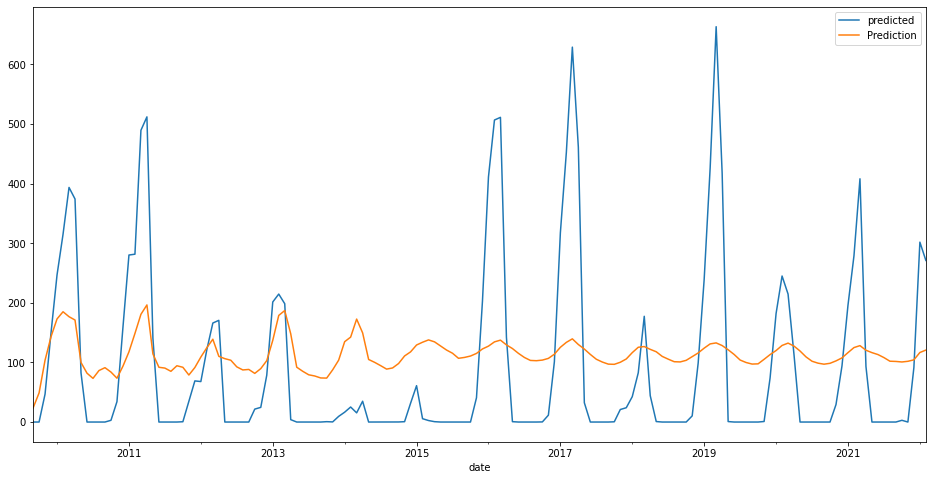

In [ ]:
#SARIMAX(4, 0, 1)x(0, 0, [1, 2], 30)	

mod = SARIMAX(train_df['predicted'], exog = train_df[['NINO12']],
              order = (4,0,1), seasonal_order=(0,0,2,30))
res = mod.fit()
start = len(train_df)
end = len(train_df) + len(test_df) - 1
prediction = res.predict(start, end, exog=test_df[['NINO12']]).rename('Prediction')
for i in range(len(prediction)):
  if prediction[i] < 0:
    prediction[i] = 0
ax = test_df['predicted'].plot(legend = True, figsize = (16, 8))
prediction.plot(legend = True)

In [ ]:
rmse(test_df['predicted'], prediction)

101.00130762597252

Using SARIMAX adding features, such as NINO data has lessened the accuracy of the model. We were however able to get an accurate model without using features. Adding feature tends to lessen the amplitude of the maximum values per year.

After implementing I foundout that SARIMAX is a univariable model, so if we can create a single column with the interplolation of the best correlation this may be a decent model to use

#XGBOOST

In [ ]:
from xgboost import XGBRegressor

In [ ]:
features = ['month', 'NINO12', 'NINO3', 'NINO4', 'NINO3.4', 'pdo_data', 'ao_data', 'site_id']

In [ ]:
df = table_creation(356)

column:d     max corr:0      shift:0
column:YR     max corr:0.054389424188989344      shift:33
column:month     max corr:0.7696042735221374      shift:-3
column:NINO12     max corr:0.6388766113403455      shift:-3
column:ANOM     max corr:0.14922867065244352      shift:20
column:NINO3     max corr:0.5491795495458948      shift:14
column:ANOM.1     max corr:0.2133969989129749      shift:19
column:NINO4     max corr:0.3743517816081935      shift:21
column:ANOM.2     max corr:0.2023105600494623      shift:18
column:NINO3.4     max corr:0.40807455108916846      shift:-6
column:ANOM.3     max corr:0.2325231482296496      shift:18
column:DATE     max corr:0      shift:0
column:pdo_data     max corr:0.24972228816202505      shift:15
column:Date_x     max corr:0      shift:0
column:ao_data     max corr:0.11740542717474459      shift:19
column:Date_y     max corr:0      shift:0
column:Accumulated_Precipitation     max corr:1.0      shift:-13
column:ANOM_seasonal     max corr:0.6212174497871656 

In [ ]:
train = df[:350]
test = df[350:]

In [ ]:
train.iloc[:, 2:]

,NINO12_shifted,NINO3_shifted,NINO4_shifted,NINO3.4_shifted,ANOM_seasonal_shifted,ANOM.1_seasonal_shifted,ANOM.2_seasonal_shifted,ANOM.3_seasonal_shifted,pdo_data_seasonal_shifted,ao_data_seasonal_shifted
d,,,,,,,,,,
1988-10-01,24.04,26.28,28.48,26.49,-0.024508,0.012655,0.008123,0.022131,-0.116730,0.147518
1988-11-01,25.86,26.38,28.41,26.99,-0.050220,0.062146,0.018655,0.048497,-0.219774,0.272314
1988-12-01,26.60,25.96,28.70,27.03,-0.029561,0.012331,0.003285,0.004052,-0.218744,0.071430
1989-01-01,25.60,25.93,28.77,26.73,-0.008415,-0.007079,-0.010071,-0.014605,-0.160793,0.030549
1989-02-01,23.36,26.17,28.85,26.18,0.015995,-0.000088,0.008297,0.012756,-0.025781,-0.054157
...,...,...,...,...,...,...,...,...,...,...
2017-07-01,19.80,27.18,29.63,25.87,0.017615,-0.033919,-0.005685,-0.028297,0.279450,0.093128
2017-08-01,20.50,26.62,30.22,26.06,0.011527,-0.023421,-0.006784,-0.015797,0.120654,-0.058002
2017-09-01,21.62,25.41,29.84,26.50,0.039583,0.000919,-0.006646,0.006807,0.036765,-0.031954


In [ ]:
X_train, y_train = train.iloc[:, 2:], train.iloc[:, 1]
X_test, y_test = test.iloc[:, 2:], test.iloc[:, 1]

In [ ]:
reg = XGBRegressor(n_estimators =250, learning_rate = 0.05)
reg.fit(X_train,
        y_train,
        eval_set =[(X_train, y_train), (X_test, y_test)],
        eval_metric = 'rmse')

[07:48:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:956.183	validation_1-rmse:825.825
[1]	validation_0-rmse:913.888	validation_1-rmse:781.802
[2]	validation_0-rmse:873.861	validation_1-rmse:741.412
[3]	validation_0-rmse:835.983	validation_1-rmse:702.213
[4]	validation_0-rmse:799.973	validation_1-rmse:667.234
[5]	validation_0-rmse:766.05	validation_1-rmse:634.363
[6]	validation_0-rmse:733.934	validation_1-rmse:603.363
[7]	validation_0-rmse:703.61	validation_1-rmse:575.17
[8]	validation_0-rmse:674.929	validation_1-rmse:550.631
[9]	validation_0-rmse:647.66	validation_1-rmse:527.876
[10]	validation_0-rmse:622.302	validation_1-rmse:505.586
[11]	validation_0-rmse:598.282	validation_1-rmse:485.426
[12]	validation_0-rmse:575.282	validation_1-rmse:468.828
[13]	validation_0-rmse:553.643	validation_1-rmse:454.353
[14]	validation_0-rmse:533.612	validation_1-rmse:441.216
[15]	validation_0-rmse:514.568	v

XGBRegressor(learning_rate=0.05, n_estimators=250)

In [ ]:
xg_pred = reg.predict(X_test)
xg_test = test
xg_test['preds'] = xg_pred

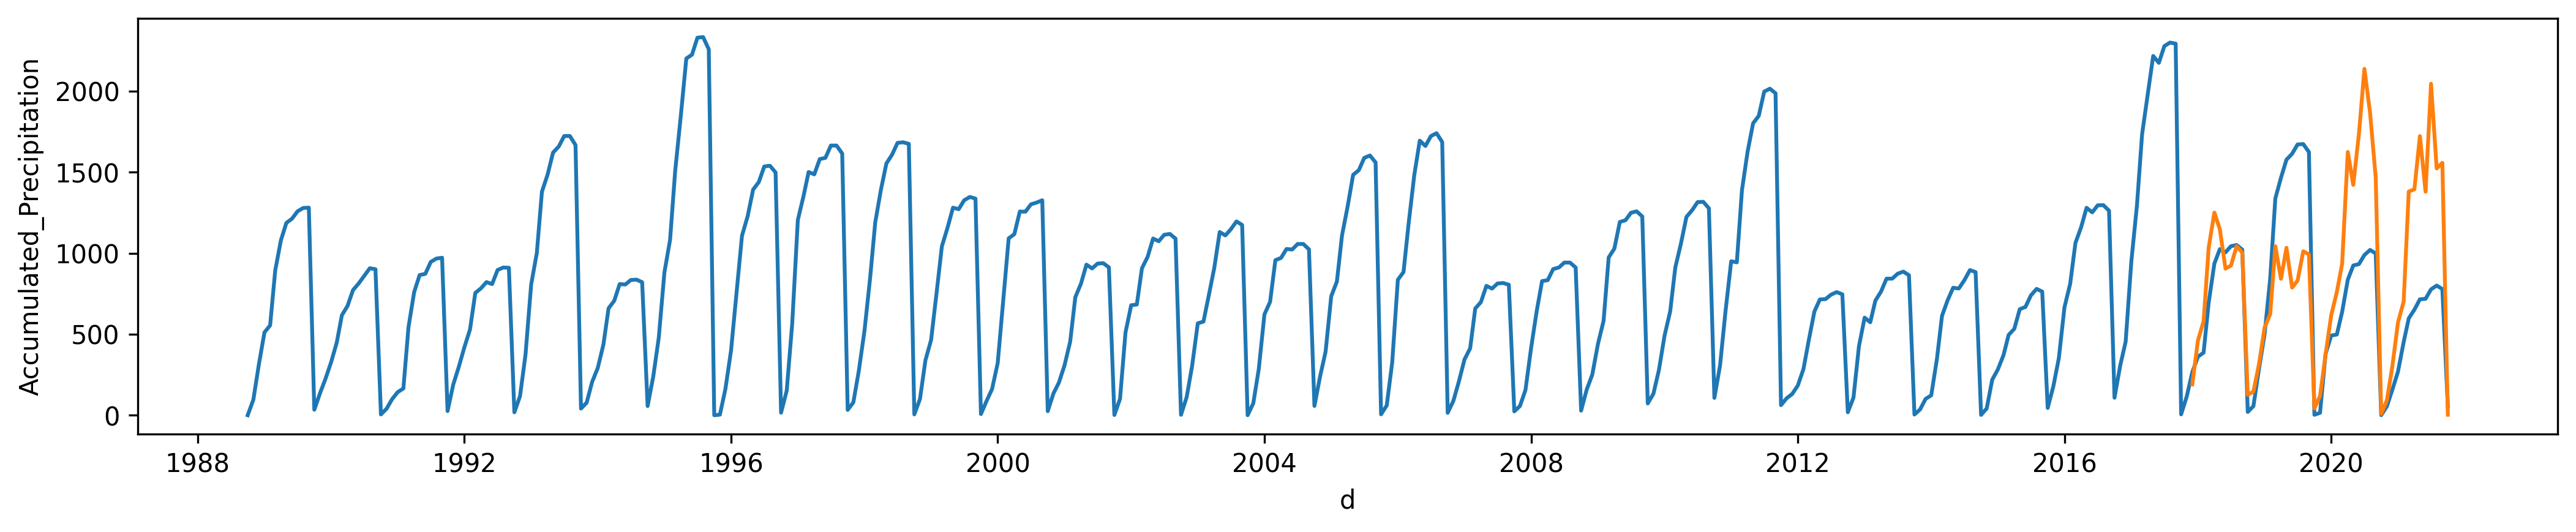

In [ ]:
fig, ax = plt.subplots()
sns.lineplot(data = df, x = df.index, y = 'Accumulated_Precipitation')
sns.lineplot(data = xg_test, x = xg_test.index, y = 'preds')

# Combine the two for a final product

Turn all of the above into functions 

Iterate through all of the stations

Embed

Update station data (monthly/weekly/daily?)

Update anomaly data (monthly?)

# GUI with Dash

In [ ]:
#for installing dash
# !pip install jupyter-dash
# !pip install dash

In [ ]:
import plotly.graph_objects as go 
import plotly.express as px
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

cwd = os.getcwd()
fig = go.Figure()
app = dash.Dash()
server = app.server

#--------------------import cleaned data--------------------

csv = pd.read_csv(cwd + "/clean_data.csv")
snotel_sites = pd.read_csv(cwd + "/snotel_sites.csv")
site_data = pd.ExcelFile(cwd + "/SNOTEL_DATA.xlsx")
combined_table = pd.read_csv(cwd + "/combined_table.csv")
anomaly_table = pd.read_csv(cwd + "/anomaly_table.csv")

#-------------------------variables--------------------------

mean_lat = snotel_sites['Latitude'].mean()
mean_lon = snotel_sites['Longitude'].mean()
date_min = pd.to_datetime("1984-01-01")

anomaly_table = anomaly_table[anomaly_table['anomaly_data'] != "--"]
anomaly_table['Date'] = pd.to_datetime(anomaly_table['Date'])
anomaly_table['anomaly_data'] = anomaly_table['anomaly_data'].astype(float)
anomaly_table['color'] = np.where(anomaly_table['anomaly_data']<0, 'red', 'green')

sites = {}
for sheet_name in site_data.sheet_names:
    sites[sheet_name] = site_data.parse(sheet_name)

#--------------------------layout----------------------------

colors = {
    'background': '#1f2630',
    'text': '#2cfec1'
}

app.layout = html.Div(children = [

    html.H1("Precipitation Forecast Sierra Nevada", style = {"text-align":"center"}),

    dcc.Dropdown(id = "Select_SNOTEL",
    options = [{"label": k.replace("_", " ").title().replace("Css", "CSS"), "value": k} for k in sites.keys()], 
    multi = False,
    value = "adin",
    style = {"width":"40%"}
    ),
    dcc.Graph(id = "graph2", style = {"display": "inline-block", "width": "67%"}),
    dcc.Graph(id = "graph1", style = {"display": "inline-block", "width": "33%", "text-align": "left"},\
    figure= px.scatter_mapbox(snotel_sites, lat = "Latitude", lon = "Longitude", hover_name = "Name", \
    center = dict(lat = mean_lat, lon = mean_lon), zoom = 5).update_layout(mapbox_style="open-street-map", margin=dict(l=0,r=0,b=0,t=0)).update_geos(fitbounds = 'locations')),
    dcc.Graph(id = "anomaly_graph", style = {"display":"inline-block"},\
    figure = px.bar(anomaly_table[anomaly_table['Date'] > date_min], x = 'Date', y = 'anomaly_data', color = 'color').update_layout(margin=dict(l=0,r=0,b=0,t=0)
))
]
)

@app.callback(
    Output('graph2', 'figure'),
    Input('Select_SNOTEL', 'value')
)
def update_output_dif(input_value):
    j = input_value
    d = combined_table[combined_table['Site'] == j]
    fig = px.line(d, x = 'Date', y = 'Precipitation Accumulation (in) Start of Day Values')
    return fig

#-----------------------run server----------------------------

if __name__ == "__main__":
    app.run_server(debug=True, use_reloader=False)


FileNotFoundError: ignored

In [ ]:
#34 SNOTEL sites
snotel_sites = pd.read_csv('/content/drive/MyDrive/DISCOVERY_FA22/snotel_list.csv')
snotel_sites = snotel_sites.drop(columns = ['ID', 'HUC', 'Date_of_Data', 'Date_Report_Created'])
snotel_sites = snotel_sites.loc[(snotel_sites['State'] == 'California') & (snotel_sites['Network'] == 'SNOTEL') ]
snotel_sites.head(3)

,Name,State,Network,County,Elevation_ft,Latitude,Longitude
5,Adin Mtn,California,SNOTEL,Modoc,6190,41.23583,-120.79192
203,Blue Lakes,California,SNOTEL,Alpine,8067,38.60800,-119.92437
293,Burnside Lake,California,SNOTEL,Alpine,8129,38.71943,-119.89420


In [ ]:
from google.colab import files
snotel_sites.to_csv('snotel_sites.csv') 
#files.download('snotel_sites.csv')

## Map

In [ ]:
import plotly 
plotly.offline.init_notebook_mode(connected=True)

In [ ]:
x = pd.read_csv('snotel_sites.csv')

In [ ]:
#this code is specific to colab may need to change for final product
mean_lat = x['Latitude'].mean()
mean_lon = x['Longitude'].mean()
fig = px.scatter_mapbox(x, lat = "Latitude", lon = "Longitude", hover_name = "Name", center = dict(lat = mean_lat, lon = mean_lon), zoom=5)
fig.update_layout(
    mapbox_style="open-street-map"
    )
#fig.update_geos(fitbounds = 'locations')
fig.show(renderer = 'colab')

# Map

In [ ]:
snotel = pd.read_csv('/content/drive/MyDrive/DISCOVERY_FA22/snotel_sites.csv')

m = leafmap.Map()
m.add_points_from_xy(snotel, y = "Latitude", x = "Longitude", color_column = "County")
m

The provided color is invalid. Using the default black color.
'lightred' is not a recognized color.


#Streamlit App

In [ ]:
import streamlit as st
import os
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from PIL import Image

#----------------Data------------------#

cwd = "/Users/andrewwilder/Desktop/discovery_fall2022/streamlit_app/"
df = pd.read_csv(cwd + 'historic_and_predicted.csv')
sites = pd.read_csv(cwd + 'snotel_sites.csv')

x = sites['Latitude']
y = sites['Longitude']
name = sites['Name']

SNOTEL_dict = SNOTEL_dict = {
  'adin': '301',
  'blue_lakes': '356',
  'burnside_lake': '1051',
  'carson_pass': '1067',
  'cedar_pass': '391',
  'css_lab': '428',
  'dismal_swamp': '446',
  'ebbetts_pass': '462',
  'echo_peak': '463',
  'fallen_leaf': '473', 
  'hagans_meadow': '508',
  'heavenly_valley': '518',
  'independence_camp': '539',
  'independence_creek': '540',
  'independence_lake': '541',
  'leavitt_lake': '574',
  'leavitt_meadows': '575',
  'lobdell_lake': '587',
  'monitor_pass': '633', 
  'poison_flat': '697',
  'rubicon_2': '724',
  'sonora_pass': '771',
  'spratt_creek': '778',
  'palisades_tahoe': '784',
  'tahoe_city_cross': '809',
  'truckee_2': '834', 
  'virginia_lakes_ridge': '846',
  'ward_creek_3': '848'}

#----------------Data------------------#


with st.sidebar:
    st.image("https://svs.gsfc.nasa.gov/vis/a000000/a004100/a004171/jetstream_uk.0030.jpg")
    st.title("Predicting Precipitation in the Sierra Nevadas")
    choice = st.radio("Navigation", ["Site List", "About", "Download"])

if choice == "Site List":
    st.title("Sites and predicted values")
    option = st.selectbox("Select SNOTEL site:",(SNOTEL_dict))

    # create figure
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=df.index, y=df[option],
                         line=dict(color='firebrick', width=2)))

    fig.add_trace(go.Scatter(x=df.index, y=df[f'{option}_predicted'],
                        line=dict(color='royalblue', width=2)))

    st.plotly_chart(fig)

    fig2 = go.FigureWidget([go.Scatter(x=x, y=y, mode='markers', hoverinfo = 'text')])

    st.plotly_chart(fig2)

if choice == "About":
    pass

if choice == "Download":
    pass

FileNotFoundError: ignored

#Visuals

In [ ]:
x1 = table_creation(301)

In [ ]:
x2 = merge_tables(301)

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning:

divide by zero encountered in log



,Precipitation,Shifted Nino1+2
Precipitation,1.000000,0.696857
Shifted Nino1+2,0.696857,1.000000


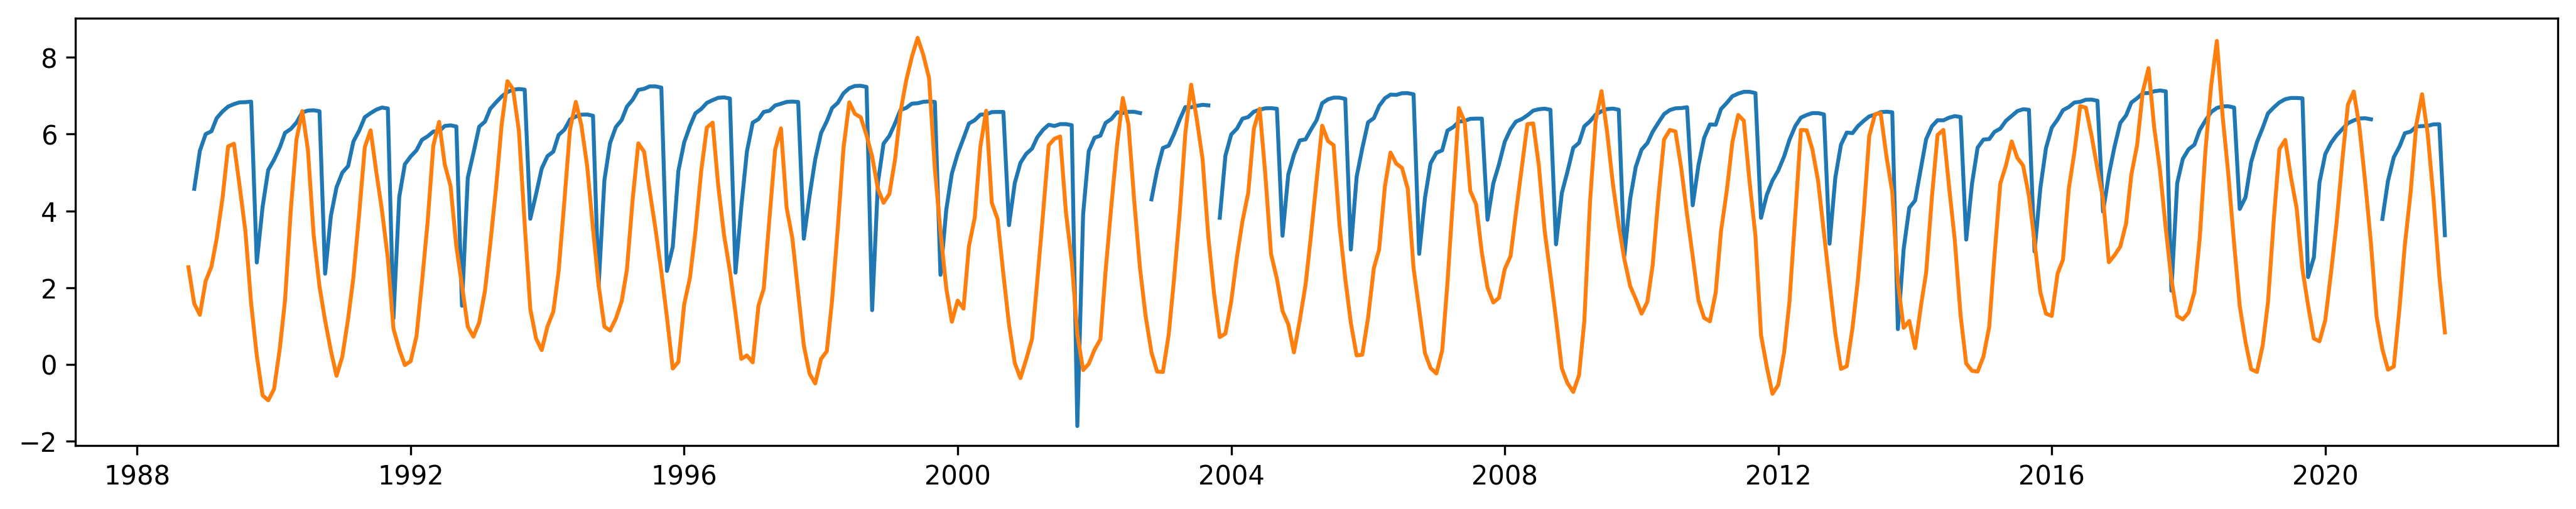

In [ ]:
plt.plot(x1.index, np.log(x1['Accumulated_Precipitation']))
plt.plot(x1.index, x1['NINO12_shifted'] - 20)

df = pd.DataFrame({'Precipitation': x1['Accumulated_Precipitation'], 'Shifted Nino1+2': x1['NINO12_shifted']})

df.corr()

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning:

divide by zero encountered in log



,Precipitation,Nino1+2
Precipitation,1.000000,0.014714
Nino1+2,0.014714,1.000000


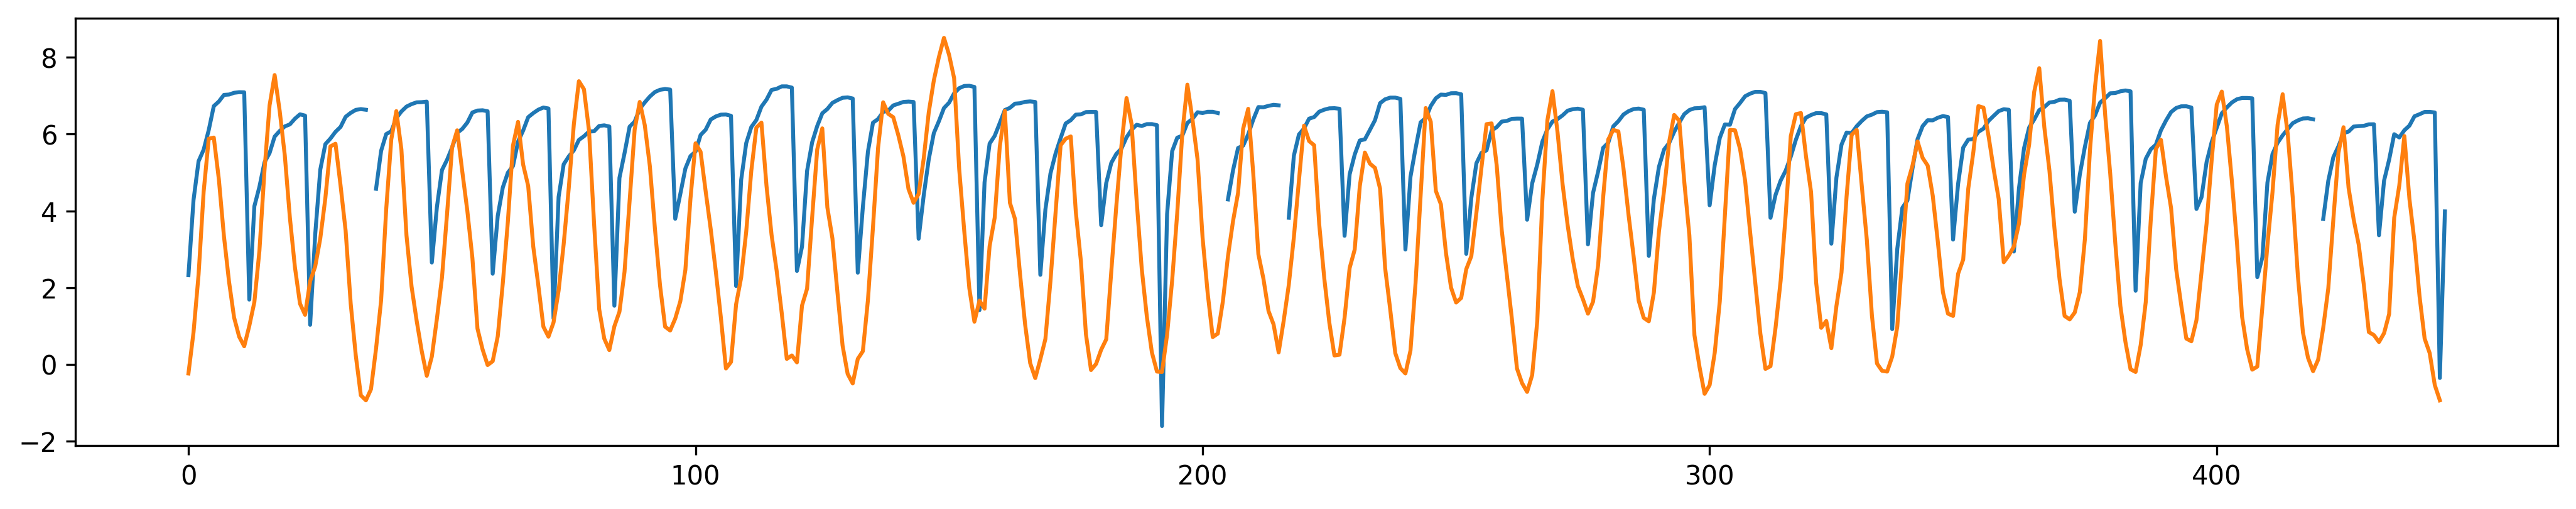

In [ ]:
plt.plot(x2.index, np.log(x2['Accumulated_Precipitation']))
plt.plot(x2.index, x2['NINO12'] - 20)

df = pd.DataFrame({'Precipitation': x2['Accumulated_Precipitation'], 'Nino1+2': x2['NINO12']})

df.corr()

Epoch 1/250
20/20 [==============================] - 6s 177ms/step - loss: 0.0899 - val_loss: 0.0447
Epoch 2/250
20/20 [==============================] - 3s 162ms/step - loss: 0.0675 - val_loss: 0.0565
Epoch 3/250
20/20 [==============================] - 3s 164ms/step - loss: 0.0680 - val_loss: 0.0376
Epoch 4/250
20/20 [==============================] - 3s 161ms/step - loss: 0.0572 - val_loss: 0.0431
Epoch 5/250
20/20 [==============================] - 3s 162ms/step - loss: 0.0610 - val_loss: 0.0317
Epoch 6/250
20/20 [==============================] - 3s 163ms/step - loss: 0.0521 - val_loss: 0.0294
Epoch 7/250
20/20 [==============================] - 3s 166ms/step - loss: 0.0483 - val_loss: 0.0661
Epoch 8/250
20/20 [==============================] - 3s 159ms/step - loss: 0.0442 - val_loss: 0.0795
Epoch 9/250
20/20 [==============================] - 3s 159ms/step - loss: 0.0427 - val_loss: 0.0857
Epoch 10/250
20/20 [==============================] - 3s 161ms/step - loss: 0.0349 - val_lo

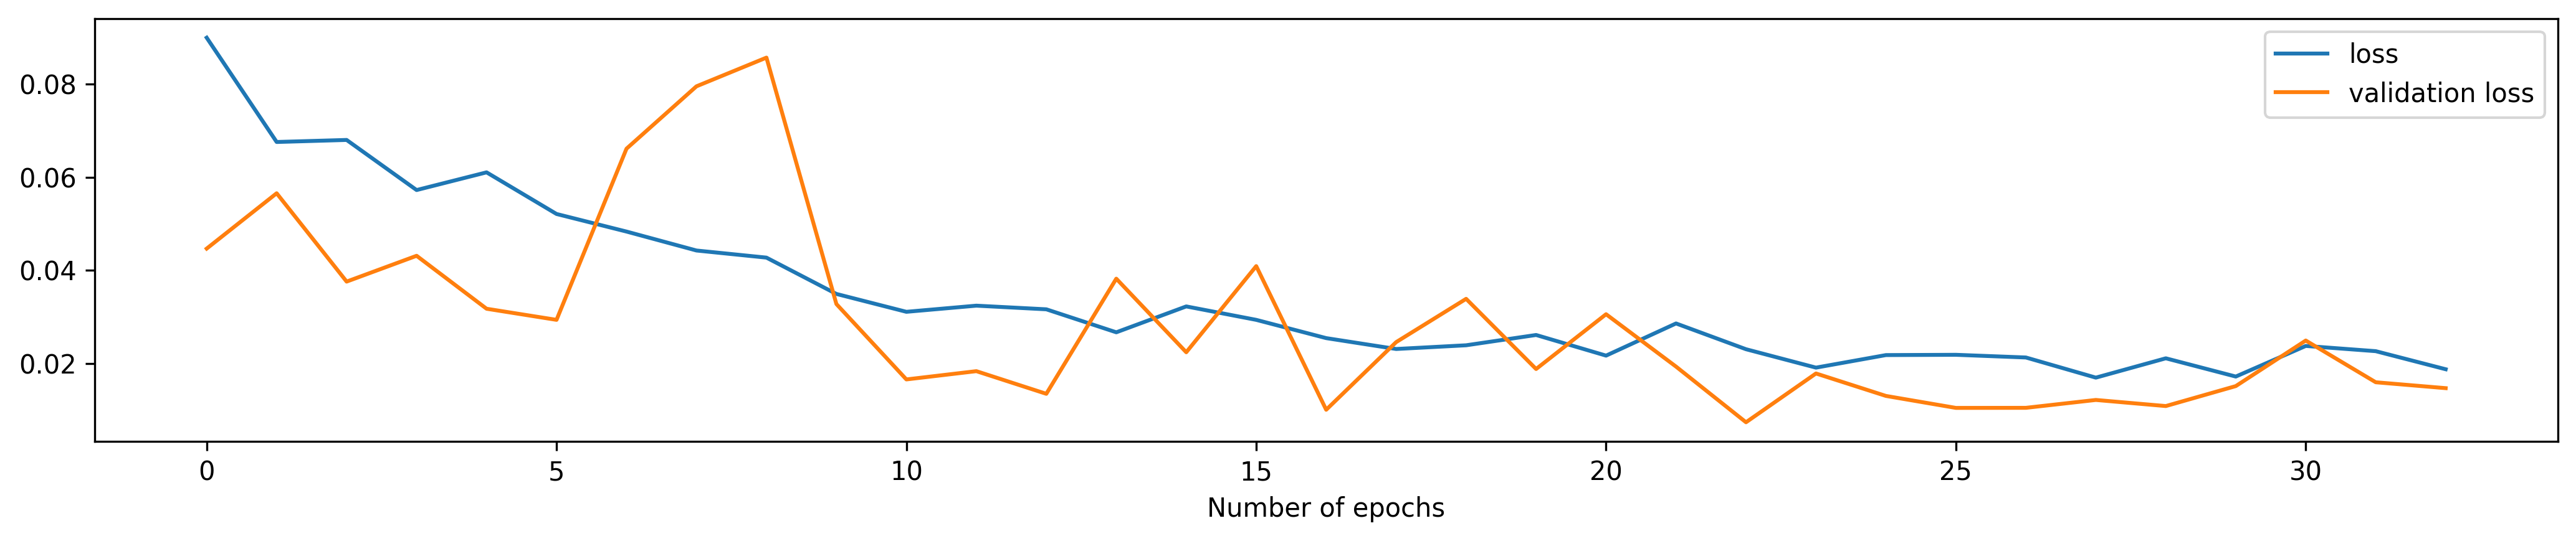

In [ ]:
xx = create_fit_save_model(301)